<a href="https://colab.research.google.com/github/Yiting916/ML/blob/main/3_01_LAB_Automobile_%E8%A8%93%E7%B7%B4%E9%9A%8E%E6%AE%B5(YT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 汽車價格預測 回歸問題

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/YiTing/Learning/Python/ML/Automobile_Train.csv')
data.head()

,symboling,Normalized-losses,make,Fuel-type,aspiration,Num-of-doors,Body-style,Drive-wheels,Engine-location,Wheel-base,...,Engine-size,Fuel-system,bore,stroke,Compression-ratio,horsepower,Peak-rpm,City-mpg,Highway-mpg,price
0,1,NaN,porsche,gas,std,two,hatchback,rwd,front,98.4,...,203,mpfi,3.94,3.11,10.0,288.0,5750.0,17,28,NaN
1,3,256.0,volkswagen,gas,std,two,hatchback,fwd,front,94.5,...,109,mpfi,3.19,3.40,8.5,90.0,5500.0,24,29,9980.0
2,2,192.0,bmw,gas,std,two,sedan,rwd,front,101.2,...,108,mpfi,3.50,2.80,8.8,101.0,5800.0,23,29,16430.0
3,0,110.0,honda,gas,std,four,sedan,fwd,front,96.5,...,92,1bbl,2.91,3.41,9.2,76.0,6000.0,30,34,7295.0
4,2,137.0,honda,gas,std,two,hatchback,fwd,front,86.6,...,92,1bbl,2.91,3.41,9.2,76.0,6000.0,31,38,6855.0


In [ ]:
#列出欄位名稱
data.columns

Index(['symboling', 'Normalized-losses', 'make', 'Fuel-type', 'aspiration',
       'Num-of-doors', 'Body-style', 'Drive-wheels', 'Engine-location',
       'Wheel-base', 'length', 'width', 'height', 'Curb-weight', 'Engine-type',
       'Num-of-cylinders', 'Engine-size', 'Fuel-system', 'bore', 'stroke',
       'Compression-ratio', 'horsepower', 'Peak-rpm', 'City-mpg',
       'Highway-mpg', 'price'],
      dtype='object')

In [ ]:
# 刪除 price為空值的資料列
data = data.dropna(subset=['price'])

# 自動前處理 (自製)

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                # self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [ ]:
# # AutoPreprocess Example
# ####################################################
# # Train Step
# mydata = pd.read_csv('../data/Automobile_Train.csv')
# ap = AutoPreprocess()
# ap.fit(mydata, ['symboling', 'Normalized-losses', 'make', 'Fuel-type', 'aspiration',
#        'Num-of-doors', 'Body-style', 'Drive-wheels', 'Engine-location',
#        'Wheel-base', 'length', 'width', 'height', 'Curb-weight', 'Engine-type',
#        'Num-of-cylinders', 'Engine-size', 'Fuel-system', 'bore', 'stroke',
#        'Compression-ratio', 'horsepower', 'Peak-rpm', 'City-mpg',
#        'Highway-mpg'])
# ap.save("C:/DATA/test.bin")

# ####################################################
# # Test and inference
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# d2 = ap2.transform(mydata) #Pandas Dataframe
# d2.head()

# ####################################################
# # Test and inference with one record
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# data_dict = {"symboling":1, "aspiration":"std"}
# d2 = ap2.transform(data_dict) #Python Dict
# print(d2)


# 前處理

In [ ]:
ap = AutoPreprocess()
ap.fit(data, ['symboling', 'Normalized-losses', 'make', 'Fuel-type', 'aspiration',
       'Num-of-doors', 'Body-style', 'Drive-wheels', 'Engine-location',
       'Wheel-base', 'length', 'width', 'height', 'Curb-weight', 'Engine-type',
       'Num-of-cylinders', 'Engine-size', 'Fuel-system', 'bore', 'stroke',
       'Compression-ratio', 'horsepower', 'Peak-rpm', 'City-mpg',
       'Highway-mpg'])
ap.save("/content/drive/MyDrive/YiTing/Learning/Python/ML/preprocess.bin")

X = ap.transform(data)
y = data['price']

# 訓練模型: 方法1

In [ ]:
from sklearn.model_selection import train_test_split
# 分割資料成訓練組跟驗證組
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [ ]:
# 訓練模型
# from sklearn.neural_network import MLPRegressor
# model = MLPRegressor(hidden_layer_sizes=(200,), max_iter=200, random_state=42)

# from sklearn.tree import DecisionTreeRegressor
# model = DecisionTreeRegressor()

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

model.fit(X_train, y_train)

RandomForestRegressor()

訓練組 R2: 0.9776869613849593
驗證組 R2: 0.9150634853423956


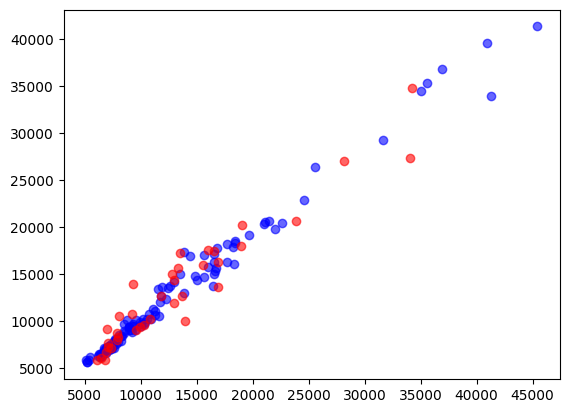

In [ ]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
print("訓練組 R2:", r2)
plt.scatter(y_train, y_pred, alpha=0.6, color='b')
# plt.show()

y_pred = model.predict(X_valid)
r2 = r2_score(y_valid, y_pred)
print("驗證組 R2:", r2)
plt.scatter(y_valid, y_pred, alpha=0.6, color='r')
plt.show()


In [ ]:
#儲存模型
import pickle

with open("/content/drive/MyDrive/YiTing/Learning/Python/ML/model.bin", "wb") as f:
    pickle.dump(model, f)


# RandomizedSearchCV版訓練: 方法2

# SVR

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVR

param_grid = [
    {"kernel": ["linear"],"C":[0.1,1,10,100,100]},
    {"kernel": ["poly"], "degree": [2, 3],"C":[0.1,1,10,100,1000],"gamma":["scale", "auto"]},
    {"kernel": ["rbf"],"C":[0.1,1,10,100,100],"gamma":["scale", "auto"]},
]

svr = SVR()

search = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, scoring="r2")
search.fit(X_train, y_train)


RandomizedSearchCV(estimator=SVR(),
                   param_distributions=[{'C': [0.1, 1, 10, 100, 100],
                                         'kernel': ['linear']},
                                        {'C': [0.1, 1, 10, 100, 1000],
                                         'degree': [2, 3],
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['poly']},
                                        {'C': [0.1, 1, 10, 100, 100],
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['rbf']}],
                   scoring='r2')

In [ ]:
search.best_params_

{'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 1000}

In [ ]:
search.cv_results_

{'mean_fit_time': array([0.01073647, 0.00674887, 0.00612254, 0.0071012 , 0.00633178,
        0.00711517, 0.00626802, 0.00853562, 0.00625224, 0.00649776]),
 'std_fit_time': array([4.40966517e-03, 1.14789865e-03, 8.40684871e-05, 1.79478036e-03,
        2.00805441e-04, 7.76742358e-04, 1.21105749e-04, 2.34727198e-03,
        2.39234643e-04, 7.93328177e-04]),
 'mean_score_time': array([0.00421371, 0.00362563, 0.00359745, 0.00358796, 0.00372167,
        0.00354819, 0.00373325, 0.00444031, 0.00386963, 0.0035234 ]),
 'std_score_time': array([7.45209749e-04, 8.06344183e-05, 5.74570770e-05, 6.95116717e-05,
        1.34078045e-04, 5.52946915e-05, 3.02076118e-04, 1.11462414e-03,
        6.04239509e-04, 9.24281399e-05]),
 'param_kernel': masked_array(data=['poly', 'linear', 'poly', 'poly', 'rbf', 'poly',
                    'poly', 'rbf', 'poly', 'poly'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
          

In [ ]:
search.best_estimator_

SVR(C=1000, kernel='poly')

In [ ]:
#儲存模型
import pickle

with open("/content/drive/MyDrive/YiTing/Learning/Python/ML/model_RandomizedSearchCV.bin", "wb") as f:
    pickle.dump(search.best_estimator_, f)

訓練組 R2: 0.8813151959640825


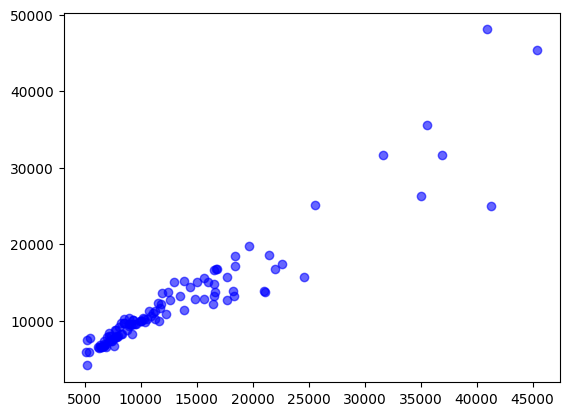

In [ ]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

model = search.best_estimator_
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
print("訓練組 R2:", r2)
plt.scatter(y_train, y_pred, alpha=0.6, color='b')
plt.show()

# y_pred = model.predict(X_valid)
# r2 = r2_score(y_valid, y_pred)
# print("驗證組 R2:", r2)
# plt.scatter(y_valid, y_pred, alpha=0.6, color='r')
# plt.show()